In [6]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from py_wave_runup.models import Stockdon2006
import matplotlib.pyplot as plt

In [7]:
data_filepath = Path("../data/clean")
wave_filepath = data_filepath / "wave.csv"
WL_filepath = data_filepath / "ObservationPointA.csv" 
slope_filepath = data_filepath / "beach_slope.csv"

WL_data = pd.read_csv(WL_filepath)
wave_data = pd.read_csv(wave_filepath)
slope_data = pd.read_csv(slope_filepath)

In [8]:
slope_data

,Unnamed: 0,lon,lat,ns,bs_deltadtm,cs_deltadtm,geometry,distance
0,202507,-95.291199,28.94369,0.00236,0.03596,0.00289,POINT (-95.291199 28.94369),0.009485


In [9]:
# Convert 'Datetime' and 'time' columns to pandas datetime objects
WL_data['Datetime'] = pd.to_datetime(WL_data['Datetime'])
wave_data['time'] = pd.to_datetime(wave_data['time'])

# Merge the two DataFrames on matching date and time
merged_df = pd.merge(
    WL_data,
    wave_data,
    left_on='Datetime',  # Match WL_data's 'Datetime' column
    right_on='time',     # Match wave_data's 'time' column
    how='inner'          # Only keep rows with matching times
)

In [10]:
# Extract the slope value (assuming it's a single value in the column 'ns')
slope_value = slope_data["ns"].iloc[0]  # Take the first value

merged_df["slope"] = slope_value
merge_filepath = data_filepath / "merged_WL_Wave_Slope.csv"
merged_df.to_csv(merge_filepath, index=False)

merged_df

,Datetime,Predicted Water Level Point A,Observed Water Level Point A,time,hs,tp,slope
0,2020-01-01 01:00:00,0.085,0.290,2020-01-01 01:00:00,0.346713,3.478156,0.00236
1,2020-01-01 02:00:00,0.113,0.306,2020-01-01 02:00:00,0.324340,3.456817,0.00236
2,2020-01-01 03:00:00,0.120,0.340,2020-01-01 03:00:00,0.306047,3.421183,0.00236
3,2020-01-01 04:00:00,0.106,0.301,2020-01-01 04:00:00,0.288575,3.403456,0.00236
4,2020-01-01 05:00:00,0.078,0.278,2020-01-01 05:00:00,0.277842,3.335890,0.00236
...,...,...,...,...,...,...,...
35055,2023-12-31 19:00:00,-0.296,-0.222,2023-12-31 19:00:00,0.442810,3.592633,0.00236
35056,2023-12-31 20:00:00,-0.240,-0.173,2023-12-31 20:00:00,0.452475,3.663421,0.00236
35057,2023-12-31 21:00:00,-0.164,-0.076,2023-12-31 21:00:00,0.463671,3.736585,0.00236
35058,2023-12-31 22:00:00,-0.074,0.037,2023-12-31 22:00:00,0.473229,3.822811,0.00236


In [11]:
# Add new columns to the DataFrame
setup_list = []
R2_list = []
swash_list = []

# Loop through each row in merged_df to compute Stockdon2006 outputs
for index, row in merged_df.iterrows():
    # Initialize Stockdon2006 model with Hs, Tp, and beta
    sto06 = Stockdon2006(Hs=row['hs'], Tp=row['tp'], beta=row['slope'])
    
    # Append values to lists
    setup_list.append(sto06.setup)
    R2_list.append(sto06.R2)
    swash_list.append(sto06.swash)

# Add the new columns to the DataFrame
merged_df['setup'] = setup_list
merged_df['R2'] = R2_list
merged_df['swash'] = swash_list

# Compute predicted water level at observation and dike
merged_df['predicted_WL_plus_wave'] = merged_df['Predicted Water Level Point A'] + merged_df['R2']

In [12]:
merged_df

,Datetime,Predicted Water Level Point A,Observed Water Level Point A,time,hs,tp,slope,setup,R2,swash,predicted_WL_plus_wave
0,2020-01-01 01:00:00,0.085,0.290,2020-01-01 01:00:00,0.346713,3.478156,0.00236,0.002114,0.110039,0.153610,0.195039
1,2020-01-01 02:00:00,0.113,0.306,2020-01-01 02:00:00,0.324340,3.456817,0.00236,0.002032,0.105777,0.147659,0.218777
2,2020-01-01 03:00:00,0.120,0.340,2020-01-01 03:00:00,0.306047,3.421183,0.00236,0.001953,0.101691,0.141956,0.221691
3,2020-01-01 04:00:00,0.106,0.301,2020-01-01 04:00:00,0.288575,3.403456,0.00236,0.001887,0.098234,0.137131,0.204234
4,2020-01-01 05:00:00,0.078,0.278,2020-01-01 05:00:00,0.277842,3.335890,0.00236,0.001815,0.094477,0.131885,0.172477
...,...,...,...,...,...,...,...,...,...,...,...
35055,2023-12-31 19:00:00,-0.296,-0.222,2023-12-31 19:00:00,0.442810,3.592633,0.00236,0.002467,0.128450,0.179311,-0.167550
35056,2023-12-31 20:00:00,-0.240,-0.173,2023-12-31 20:00:00,0.452475,3.663421,0.00236,0.002543,0.132403,0.184829,-0.107597
35057,2023-12-31 21:00:00,-0.164,-0.076,2023-12-31 21:00:00,0.463671,3.736585,0.00236,0.002626,0.136708,0.190838,-0.027292
35058,2023-12-31 22:00:00,-0.074,0.037,2023-12-31 22:00:00,0.473229,3.822811,0.00236,0.002714,0.141297,0.197244,0.067297


In [13]:
print(np.max(merged_df['Observed Water Level Point A']))
print(np.min(merged_df['Observed Water Level Point A']))
print(np.max(merged_df['R2']))
print(np.min(merged_df['R2']))
print(np.max(merged_df['hs']))
print(np.min(merged_df['hs']))
print(np.max(merged_df['tp']))
print(np.min(merged_df['tp']))

1.657
-0.835
0.8674279688804523
0.0416853609526636
4.328045
0.11136216
9.416501
2.1343946


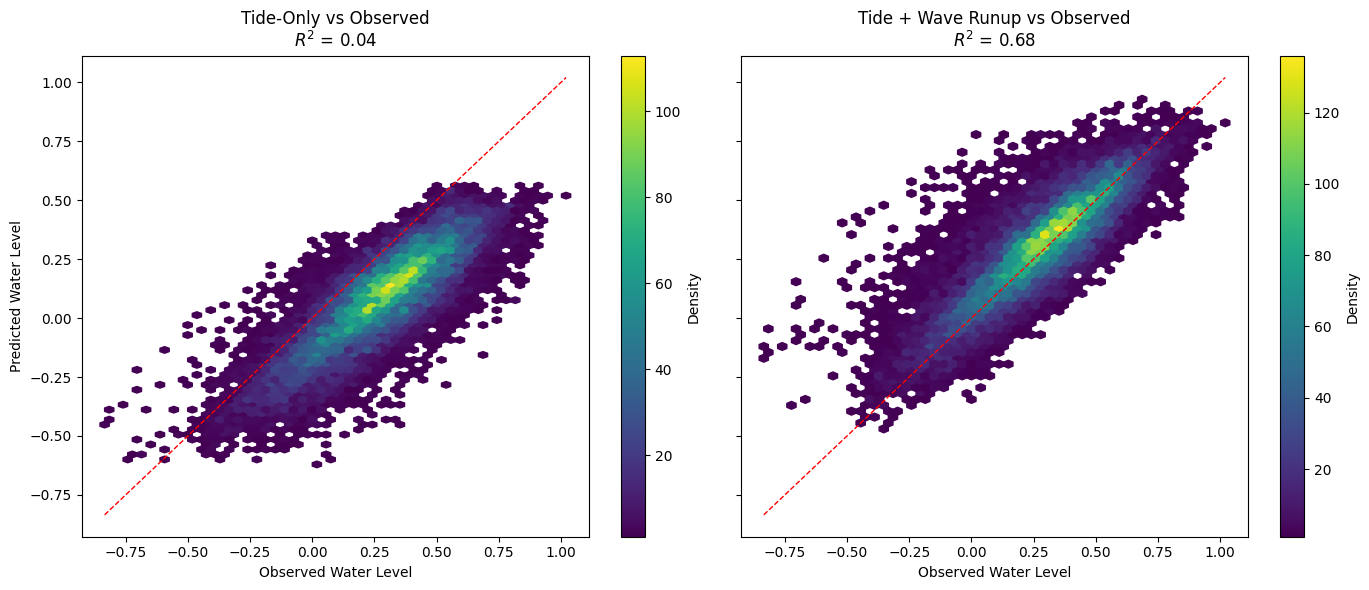

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Extract data for convenience
x_obs = merged_df['Observed Water Level Point A']
y_pred1 = merged_df['Predicted Water Level Point A']
y_pred2 = merged_df['predicted_WL_plus_wave']

# Compute R² values
r2_pred1 = r2_score(x_obs, y_pred1)
r2_pred2 = r2_score(x_obs, y_pred2)

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred1, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"Tide-Only vs Observed\n$R^2$ = {r2_pred1:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Predicted Water Level")
fig.colorbar(hb1, ax=axs[0], label='Density')

# Plot 2: Wave-Corrected Predicted vs Observed Water Level
hb2 = axs[1].hexbin(x_obs, y_pred2, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"Tide + Wave Runup vs Observed\n$R^2$ = {r2_pred2:.2f}")
axs[1].set_xlabel("Observed Water Level")
fig.colorbar(hb2, ax=axs[1], label='Density')

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
# Filter data for the specified date range
filtered_data = merged_df[(merged_df['Datetime'] >= '2023-03-01') & (merged_df['Datetime'] < '2023-05-01')]

# Extract the filtered time series
filtered_datetime = filtered_data['Datetime']
filtered_x_obs = filtered_data['Observed Water Level Point A']
filtered_y_pred1 = filtered_data['Predicted Water Level Point A']
filtered_y_pred2 = filtered_data['predicted_WL_plus_wave']


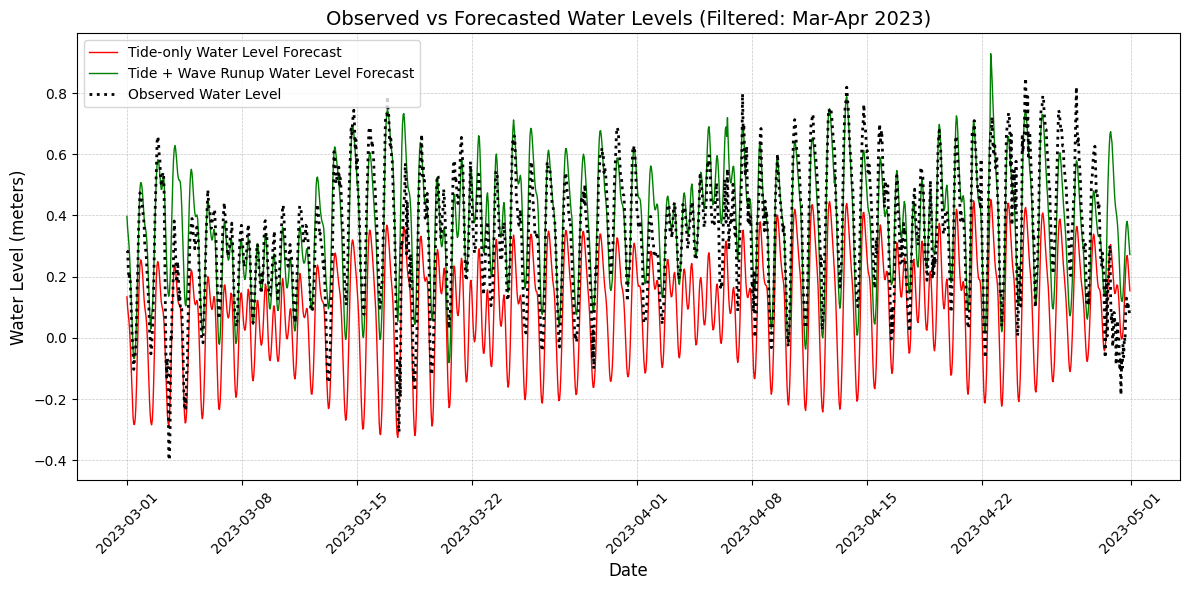

In [23]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot tide-only water level forecast
ax.plot(filtered_datetime, filtered_y_pred1, color="red", linewidth=1, label="Tide-only Water Level Forecast")

# Plot tide + wave runup water level forecast
ax.plot(filtered_datetime, filtered_y_pred2, color="green", linewidth=1, label="Tide + Wave Runup Water Level Forecast")

# Plot observed water levels
ax.plot(filtered_datetime, filtered_x_obs, color="black", linewidth=2, linestyle=":", label="Observed Water Level")

# Customize x-axis
ax.set_xlabel("Date", fontsize=12)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

# Customize y-axis
ax.set_ylabel("Water Level (meters)", fontsize=12)

# Add a grid for better readability
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend
ax.legend(loc="upper left", fontsize=10)

# Add a title
ax.set_title("Observed vs Forecasted Water Levels (Filtered: Mar-Apr 2023)", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from py_wave_runup.models import Stockdon2006

# Ensemble parameters
N = 100  # Number of particles
D = 4  # State vector dimensions (water level, setup, swash, R2)

def initialize_ensemble(params):
    prior_mean = np.array([
        params["x1_mean"],
        params["setup_mean"],
        params["swash_mean"],
        params["R2_mean"]
    ])
    prior_cov = np.diag([
        params["initial_cov"]**2,
        params["initial_cov"]**2,
        params["initial_cov"]**2,
        params["initial_cov"]**2
    ])
    X = scipy.stats.multivariate_normal.rvs(mean=prior_mean, cov=prior_cov, size=N)
    X = np.reshape(X, (N, D))
    return X

# Define a forecast model
def forecast(X, hs, tp, slope, forecast_error):
    """
    Forecast the next state of the particles.
    """
    x1, setup, swash, R2 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    Q = np.diag([forecast_error**2] * 4)
    noise = scipy.stats.multivariate_normal.rvs(mean=np.zeros(Q.shape[0]), cov=Q, size=X.shape[0])

    # Use Stockdon2006 to compute setup, swash, and R2
    stockdon = Stockdon2006(Hs=hs, Tp=tp, beta=slope)
    setup_new = stockdon.setup + noise[:, 1]
    swash_new = stockdon.swash + noise[:, 2]
    R2_new = stockdon.R2 + noise[:, 3]

    # Update water level based on setup and R2
    x1_new = x1 + R2_new + noise[:, 0]

    return np.vstack([x1_new, setup_new, swash_new, R2_new]).T

# Define assimilation step
def assimilation(X, w, y_star, observation_error):
    """
    Assimilation step using a particle filter approach.
    """
    def stochastic_universal_resampling(weights):
        N = len(weights)
        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.0  # Ensure the last value is exactly 1
        offset = np.random.uniform(0, 1 / N)
        pointers = offset + np.arange(N) / N
        indices = np.searchsorted(cumulative_sum, pointers)
        return indices

    H = np.array([
        [1, 0, 0, 0]  # Observation maps to water level (x1)
    ])

    R = np.diag([observation_error**2])

    Y = H @ X.T
    likelihood = np.array([
        scipy.stats.multivariate_normal.pdf(y_star, mean=Y[:, i], cov=R)
        for i in range(Y.shape[1])
    ])

    # Normalize weights, handle zero likelihood gracefully
    w *= likelihood
    if np.sum(w) == 0:
        w = np.ones_like(w) / len(w)
    else:
        w /= np.sum(w)

    resampled_indices = stochastic_universal_resampling(w)
    X = X[resampled_indices, :]
    w = np.ones_like(w) / len(w)
    return X, w

# optimal_params = {'x1_mean': 0.21284092080822192, 
#                   'setup_mean': 0.17146648394744082, 
#                   'swash_mean': 0.07758326610306888, 
#                   'R2_mean': 0.4996948510819952, 
#                   'initial_cov': 0.13192498597072155, 
#                   'forecast_error': 0.2719382462915056, 
#                   'observation_error': 0.051386620271833}

# # Re-run Particle Filter with optimized parameters
# X = initialize_ensemble(optimal_params)
# w = np.ones(N) / N
# pf_predictions = []

# for _, row in merged_df.iterrows():
#     hs, tp, slope = row['hs'], row['tp'], row['slope']
#     observed_wl = row['Observed Water Level Point A']

#     X, w = assimilation(X, w, np.array([observed_wl]), optimal_params["observation_error"])
#     X = forecast(X, hs, tp, slope, optimal_params["forecast_error"])
#     pf_predictions.append(np.mean(X[:, 0], axis=0))

# # Evaluate RMSE
# rmse = np.sqrt(mean_squared_error(merged_df['Observed Water Level Point A'], pf_predictions))
# print(f"RMSE of Optimized Particle Filter Model: {rmse}")

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(merged_df['Observed Water Level Point A'], label="Observed Water Level", marker="o")
# plt.plot(pf_predictions, label="Particle Filter Prediction", linestyle="--")
# plt.xlabel("Observation Index")
# plt.ylabel("Water Level")
# plt.title("Optimized Particle Filter Model for Predicted Water Levels")
# plt.legend()
# plt.show()

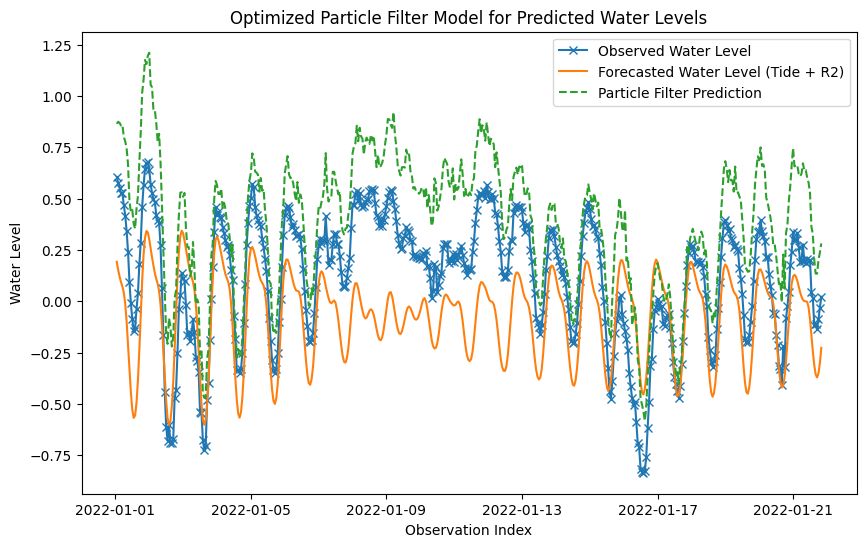

In [40]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Datetime'][:500], merged_df['Observed Water Level Point A'][:500], label="Observed Water Level", marker="x")
plt.plot(merged_df['Datetime'][:500], merged_df['Predicted Water Level Point A'][:500], label="Forecasted Water Level (Tide + R2)")
plt.plot(merged_df['Datetime'][:500], pf_predictions[:500], label="Particle Filter Prediction", linestyle="--")
plt.xlabel("Observation Index")
plt.ylabel("Water Level")
plt.title("Optimized Particle Filter Model for Predicted Water Levels")
plt.legend()
plt.show()

In [41]:
print(len(pf_predictions))
print(len(merged_df['Predicted Water Level Point A']))

17518
17518


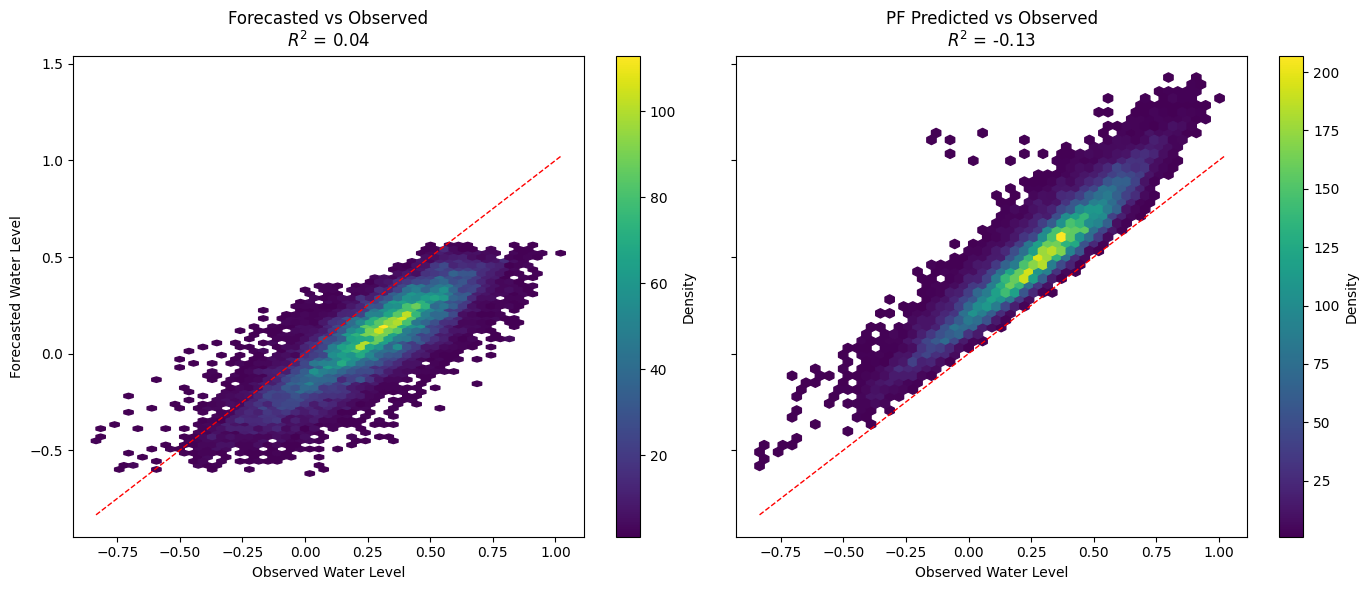

In [43]:
# Extract data for convenience
x_obs = merged_df['Observed Water Level Point A']
y_pred1 = merged_df['Predicted Water Level Point A']
y_pred2 = pf_predictions

# Compute R² values
r2_pred1 = r2_score(x_obs, y_pred1)
r2_pred2 = r2_score(x_obs, y_pred2)

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred1, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"Forecasted vs Observed\n$R^2$ = {r2_pred1:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Forecasted Water Level")
fig.colorbar(hb1, ax=axs[0], label='Density')

# Plot 2: PF Predictions vs Observed Water Level
hb2 = axs[1].hexbin(x_obs, y_pred2, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"PF Predicted vs Observed\n$R^2$ = {r2_pred2:.2f}")
axs[1].set_xlabel("Observed Water Level")
fig.colorbar(hb2, ax=axs[1], label='Density')

# Adjust layout
plt.tight_layout()
plt.show()

In [91]:
import optuna
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from py_wave_runup.models import Stockdon2006

# Ensemble parameters
N = 100  # Number of particles
D = 4  # State vector dimensions (water level, setup, swash, R2)

def initialize_ensemble(params):
    prior_mean = np.array([
        params["x1_mean"],
        params["setup_mean"],
        params["swash_mean"],
        params["R2_mean"]
    ])
    prior_cov = np.diag([
        params["initial_cov"]**2,
        params["initial_cov"]**2,
        params["initial_cov"]**2,
        params["initial_cov"]**2
    ])
    X = scipy.stats.multivariate_normal.rvs(mean=prior_mean, cov=prior_cov, size=N)
    X = np.reshape(X, (N, D))
    return X

# Define a forecast model
def forecast(X, hs, tp, slope, forecast_error):
    """
    Forecast the next state of the particles.
    """
    x1, setup, swash, R2 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    Q = np.diag([forecast_error**2] * 4)
    noise = scipy.stats.multivariate_normal.rvs(mean=np.zeros(Q.shape[0]), cov=Q, size=X.shape[0])

    setup_new = []
    swash_new = []
    R2_new = []

    hs = hs + noise[:, 1]
    tp = tp + noise[:, 2]

    for h, t in zip(hs, tp):
        stockdon = Stockdon2006(Hs=h, Tp=t, beta=slope)
        setup_new.append(stockdon.setup)
        swash_new.append(stockdon.swash)
        R2_new.append(stockdon.swash)
    
    R2_new = np.mean(R2_new) + noise[:, 3]

    # # Use Stockdon2006 to compute setup, swash, and R2
    # stockdon = Stockdon2006(Hs=hs, Tp=tp, beta=slope)
    # setup_new = stockdon.setup + noise[:, 1]
    # swash_new = stockdon.swash + noise[:, 2]
    # R2_new = stockdon.R2 + noise[:, 3]

    # Update water level based on setup and R2
    x1_new = x1 + R2_new + noise[:, 0]

    return np.vstack([x1_new, setup_new, swash_new, R2_new]).T

# Define assimilation step
def assimilation(X, w, y_star, observation_error):
    """
    Assimilation step using a particle filter approach.
    """
    def stochastic_universal_resampling(weights):
        N = len(weights)
        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.0  # Ensure the last value is exactly 1
        offset = np.random.uniform(0, 1 / N)
        pointers = offset + np.arange(N) / N
        indices = np.searchsorted(cumulative_sum, pointers)
        return indices

    H = np.array([
        [1, 0, 0, 0]  # Observation maps to water level (x1)
    ])

    R = np.diag([observation_error**2])

    Y = H @ X.T
    likelihood = np.array([
        scipy.stats.multivariate_normal.pdf(y_star, mean=Y[:, i], cov=R)
        for i in range(Y.shape[1])
    ])

    # Normalize weights, handle zero likelihood gracefully
    w *= likelihood
    if np.sum(w) == 0:
        w = np.ones_like(w) / len(w)
    else:
        w /= np.sum(w)

    resampled_indices = stochastic_universal_resampling(w)
    X = X[resampled_indices, :]
    w = np.ones_like(w) / len(w)
    return X, w

# Define the Optuna objective function
def objective(trial):
    # Suggest parameters using Optuna
    params = {
        "x1_mean": trial.suggest_float("x1_mean", -0.835, 1.021),
        "setup_mean": trial.suggest_float("setup_mean", 0.14925247, 3.0059977),
        "swash_mean": trial.suggest_float("swash_mean", 2.37282, 8.45479),
        "R2_mean": trial.suggest_float("R2_mean", 0.05243218764602407, 0.7489840889854656),
        "initial_cov": trial.suggest_float("initial_cov", 0.01, 2),
        "forecast_error": trial.suggest_float("forecast_error", 0.01, 2),
        "observation_error": trial.suggest_float("observation_error", 0.01, 2)
    }

    X = initialize_ensemble(params)
    w = np.ones(N) / N

    pf_predictions = []

    for _, row in merged_df.iterrows():
        hs, tp, slope = row['hs'], row['tp'], row['slope']
        observed_wl = row['Observed Water Level Point A']

        X, w = assimilation(X, w, np.array([observed_wl]), params["observation_error"])
        X = forecast(X, hs, tp, slope, params["forecast_error"])
        pf_predictions.append(np.mean(X[:, 0], axis=0))

    return abs(r2_score(merged_df['Observed Water Level Point A'], pf_predictions) - 1)

# Initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get the best parameters
optimal_params = study.best_params
print("Optimal Parameters Found:", optimal_params)

# Re-run Particle Filter with optimized parameters
X = initialize_ensemble(optimal_params)
w = np.ones(N) / N
pf_predictions = []

for _, row in merged_df.iterrows():
    hs, tp, slope = row['hs'], row['tp'], row['slope']
    observed_wl = row['Observed Water Level Point A']

    X, w = assimilation(X, w, np.array([observed_wl]), optimal_params["observation_error"])
    X = forecast(X, hs, tp, slope, optimal_params["forecast_error"])
    pf_predictions.append(np.mean(X[:, 0], axis=0))

# Evaluate R2
r2_test = r2_score(merged_df['Observed Water Level Point A'], pf_predictions)
print(f"R2 of Optimized Particle Filter Model: {r2_test}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Predicted Water Level Point A'], label="Predicted Water Level", marker="x")
plt.plot(merged_df['Observed Water Level Point A'], label="Observed Water Level", marker="o")
plt.plot(pf_predictions, label="Particle Filter Prediction", linestyle="--")
plt.xlabel("Observation Index")
plt.ylabel("Water Level")
plt.title("Optimized Particle Filter Model for Predicted Water Levels")
plt.legend()
plt.show()

[I 2025-01-07 13:31:39,363] A new study created in memory with name: no-name-039faf99-1b7c-4122-a6ac-60fdf3afd4e8


d:\TUDELFT\MORE\Project\CODE\Group Project\code\py_wave_runup\models.py:84: RuntimeWarning: invalid value encountered in sqrt
  self.zeta = self.beta / (self.Hs / self.Lp) ** (0.5)
d:\TUDELFT\MORE\Project\CODE\Group Project\code\py_wave_runup\models.py:189: RuntimeWarning: invalid value encountered in sqrt
  result = 0.35 * self.beta * (self.Hs * self.Lp) ** 0.5
d:\TUDELFT\MORE\Project\CODE\Group Project\code\py_wave_runup\models.py:201: RuntimeWarning: invalid value encountered in sqrt
  result = 0.75 * self.beta * (self.Hs * self.Lp) ** 0.5
d:\TUDELFT\MORE\Project\CODE\Group Project\code\py_wave_runup\models.py:213: RuntimeWarning: invalid value encountered in sqrt
  result = 0.06 * (self.Hs * self.Lp) ** 0.5
[W 2025-01-07 13:35:38,209] Trial 0 failed with parameters: {'x1_mean': -0.7809987694571224, 'setup_mean': 1.1720928212197388, 'swash_mean': 3.1667082070616672, 'R2_mean': 0.24362937427855397, 'initial_cov': 1.830496325860052, 'forecast_error': 0.3504852736642096, 'observation_e

ValueError: Input contains NaN.

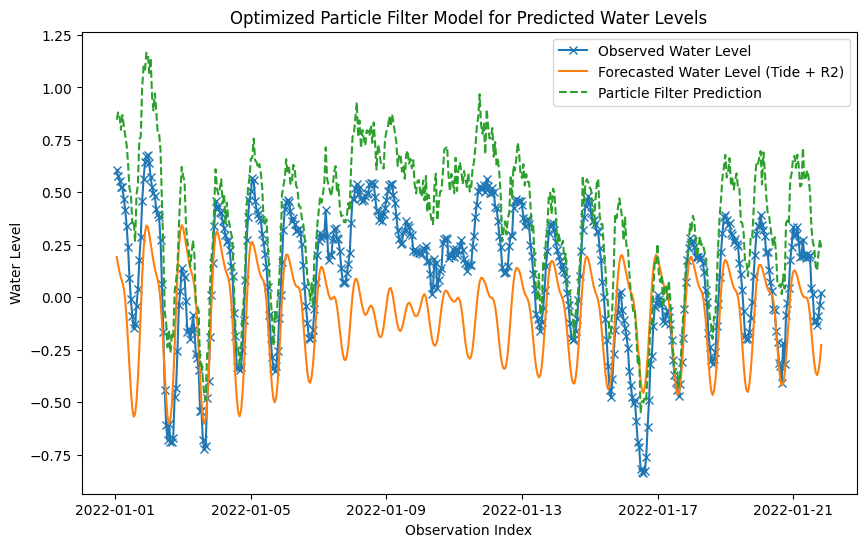

In [86]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Datetime'][:500], merged_df['Observed Water Level Point A'][:500], label="Observed Water Level", marker="x")
plt.plot(merged_df['Datetime'][:500], merged_df['Predicted Water Level Point A'][:500], label="Forecasted Water Level (Tide + R2)")
plt.plot(merged_df['Datetime'][:500], pf_predictions[:500], label="Particle Filter Prediction", linestyle="--")
plt.xlabel("Observation Index")
plt.ylabel("Water Level")
plt.title("Optimized Particle Filter Model for Predicted Water Levels")
plt.legend()
plt.show()

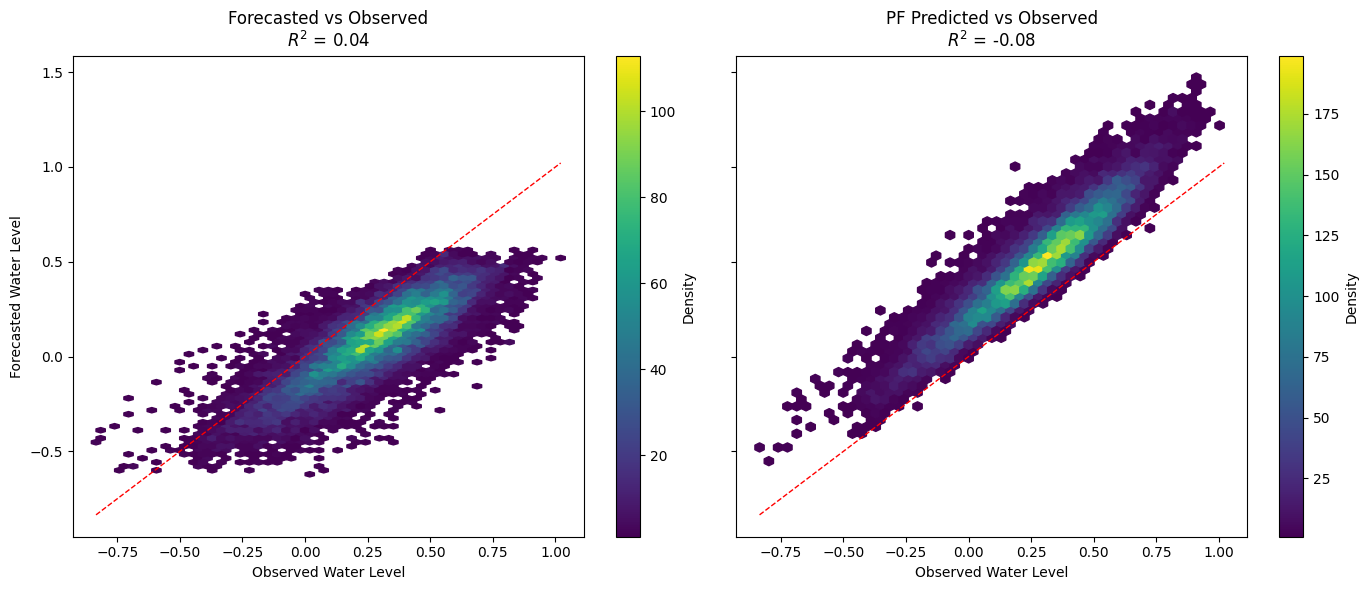

In [85]:
# Extract data for convenience
x_obs = merged_df['Observed Water Level Point A']
y_pred1 = merged_df['Predicted Water Level Point A']
y_pred2 = pf_predictions

# Compute R² values
r2_pred1 = r2_score(x_obs, y_pred1)
r2_pred2 = r2_score(x_obs, y_pred2)

# Create the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot 1: Predicted Water Level vs Observed Water Level
hb1 = axs[0].hexbin(x_obs, y_pred1, gridsize=50, cmap='viridis', mincnt=1)
axs[0].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[0].set_title(f"Forecasted vs Observed\n$R^2$ = {r2_pred1:.2f}")
axs[0].set_xlabel("Observed Water Level")
axs[0].set_ylabel("Forecasted Water Level")
fig.colorbar(hb1, ax=axs[0], label='Density')

# Plot 2: PF Predictions vs Observed Water Level
hb2 = axs[1].hexbin(x_obs, y_pred2, gridsize=50, cmap='viridis', mincnt=1)
axs[1].plot([x_obs.min(), x_obs.max()], [x_obs.min(), x_obs.max()], color='red', linestyle='--', linewidth=1)
axs[1].set_title(f"PF Predicted vs Observed\n$R^2$ = {r2_pred2:.2f}")
axs[1].set_xlabel("Observed Water Level")
fig.colorbar(hb2, ax=axs[1], label='Density')

# Adjust layout
plt.tight_layout()
plt.show()

RMSE of Particle Filter Model: 0.40555452505752826


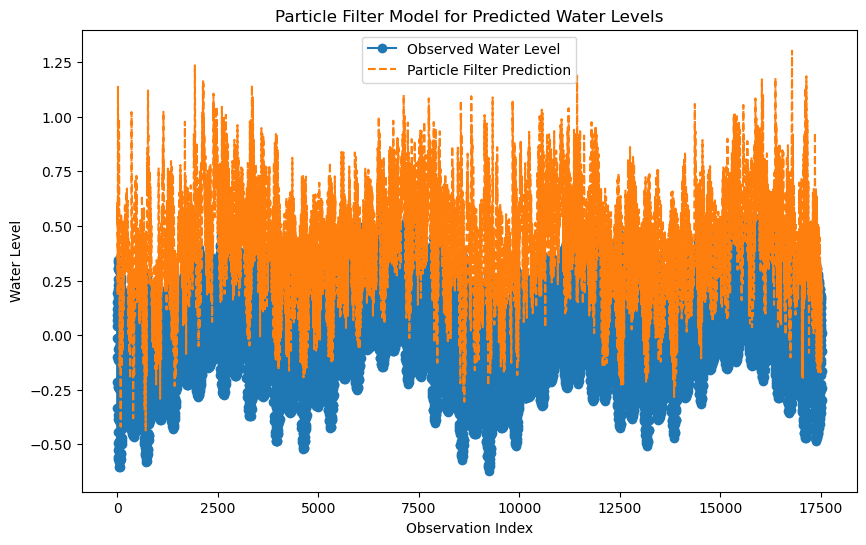

In [18]:
from sklearn.metrics import mean_squared_error

# Ensemble parameters
N = 200  # Number of particles
D = 4  # State vector dimensions (water level, setup, swash, R2)

prior_mean = np.array([
    0.4,  # x1_mean (Water Level Prediction)
    0.4,  # setup
    0.4,  # swash
    0.4   # R2
])

# Define the prior covariance (generalized)
prior_cov = np.diag([
    0.4**2,  # Initial_cov for water level
    0.4**2,  # Initial_cov for setup
    0.4**2,  # Initial_cov for swash
    0.4**2   # Initial_cov for R2
])

# Generate the ensemble
X = scipy.stats.multivariate_normal.rvs(mean=prior_mean, cov=prior_cov, size=N)
X = np.reshape(X, (N, D))
X_initial = X.copy()

# Define a forecast model
def forecast(X, hs, tp, slope):
    """
    Forecast the next state of the particles.
    """
    x1, setup, swash, R2 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    forecast_noise = 0.2
    Q = np.diag([forecast_noise**2] * 4)
    noise = scipy.stats.multivariate_normal.rvs(mean=np.zeros(Q.shape[0]), cov=Q, size=X.shape[0])

    # Use Stockdon2006 to compute setup, swash, and R2
    stockdon = Stockdon2006(Hs=hs, Tp=tp, beta=slope)
    setup_new = stockdon.setup + noise[:, 1]
    swash_new = stockdon.swash + noise[:, 2]
    R2_new = stockdon.R2 + noise[:, 3]

    # Update water level based on setup and R2
    x1_new = x1 + setup_new + R2_new + noise[:, 0]

    return np.vstack([x1_new, setup_new, swash_new, R2_new]).T

# Define assimilation step
def assimilation(X, w, y_star):
    """
    Assimilation step using a particle filter approach.
    """
    def stochastic_universal_resampling(weights):
        """
        Stochastic universal resampling (SUR) with edge case handling.
        """
        N = len(weights)
        weights /= np.sum(weights)  # Normalize weights to sum to 1
        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.0  # Ensure the last value is exactly 1.0 to prevent indexing errors
        offset = np.random.uniform(0, 1 / N)
        pointers = offset + np.arange(N) / N
        indices = []
        j = 0

        for pointer in pointers:
            while pointer > cumulative_sum[j]:
                j += 1
            indices.append(j)

        return indices

    H = np.array([
        [1, 0, 0, 0]  # Observation maps to water level (x1)
    ])

    observation_error = 0.35
    R = np.diag([observation_error**2])

    Y = H @ X.T
    likelihood = np.array([
        scipy.stats.multivariate_normal.pdf(y_star, mean=Y[:, i], cov=R)
        for i in range(Y.shape[1])
    ])
    w *= likelihood
    w /= np.sum(w)
    resampled_indices = stochastic_universal_resampling(w)
    X = X[resampled_indices, :]
    w = np.ones_like(w) / len(w)
    return X, w

# Particle Filter for Water Level Prediction
def particle_filter_water_level(merged_df):
    particles = X_initial
    weights = np.ones(N) / N
    pf_predictions = []

    for _, row in merged_df.iterrows():
        hs, tp, slope = row['hs'], row['tp'], row['slope']
        observed_wl = row['Predicted Water Level Point A']

        particles, weights = assimilation(particles, weights, np.array([observed_wl]))
        particles = forecast(particles, hs, tp, slope)
        pf_predictions.append(np.mean(particles[:, 0], axis=0))

    return np.array(pf_predictions)

# Run Particle Filter
pf_predictions = particle_filter_water_level(merged_df)

# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(merged_df['Predicted Water Level Point A'], pf_predictions))
print(f"RMSE of Particle Filter Model: {rmse}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Predicted Water Level Point A'], label="Observed Water Level", marker="o")
plt.plot(pf_predictions, label="Particle Filter Prediction", linestyle="--")
plt.xlabel("Observation Index")
plt.ylabel("Water Level")
plt.title("Particle Filter Model for Predicted Water Levels")
plt.legend()
plt.show()
